# GecoDB

GecoDB is a dataset, based on DECOW16A (Schäfer & Pankratz 2018), with only N+N compounds with frequency higher than 5 left.

This notebook gives a very short insight into dataset composition, namely, distribution of counts, link types, and first constituents.

In [ ]:
# set high-level working dir
%cd ../../../

In [2]:
from dekor.utils.gecodb_parser import parse_gecodb

In [3]:
gecodb = parse_gecodb("./resources/gecodb_v05.tsv")	# unarchive it from "resources/gecodb_v05.zip"
gecodb.head()

,raw,count,fc_count,compound
0,land_kreis,402155,3643,landkreis <-- land_kreis
1,land_+es_regierung,213583,3643,landesregierung <-- land_+es_regierung
2,land_gericht,169200,3643,landgericht <-- land_gericht
3,land_wirt,124963,3643,landwirt <-- land_wirt
4,land_+es_verband,106107,3643,landesverband <-- land_+es_verband


In [4]:
import os
out_dir = "./dekor/gecodb_datasets/inspect/"

## Compound Corpus Frequency Distribution 

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use("ggplot")

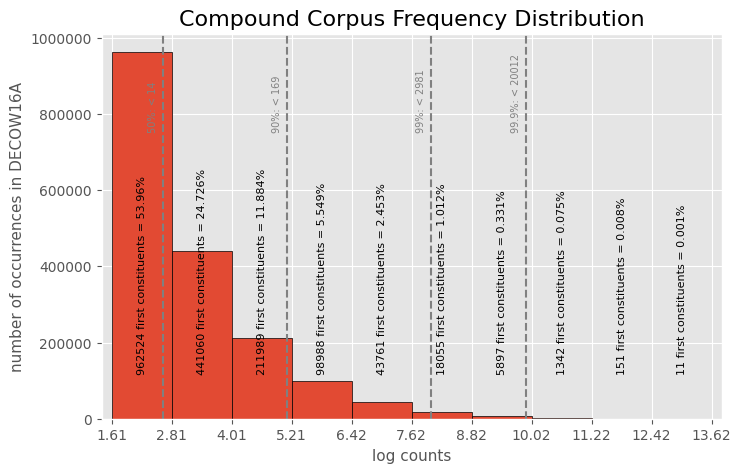

In [9]:
counts = gecodb["count"].values
log_counts = np.log(counts)

plt.figure(figsize=(8, 5))

data = plt.hist(log_counts, edgecolor="black")
ticks = data[1]

plt.xticks(ticks)
# apply full integer formatting for the y-axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, _: int(v)))
plt.xlabel("log counts", fontsize=11)
plt.ylabel("number of occurrences in DECOW16A", fontsize=11)

plt.title("Compound Corpus Frequency Distribution", fontsize=16)

# add percentiles
percentages = [50, 90, 99, 99.9]
percentiles = np.percentile(log_counts, percentages)
for percentage, percentile in zip(percentages, percentiles):
	plt.axvline(
		x=percentile,
		linestyle="--",
		color="grey"
	)
	# add text label next to the line
	plt.text(
		x=percentile - 0.3,
		y=plt.ylim()[1] * 0.75,  # lift text to 25% of max height
		# s=f"{percentage}% of first constituents occur {int(np.exp(percentile))} times or less",
		s=f"{percentage}%: < {round(np.exp(percentile))}",
		rotation=90,
		fontsize=7,
		color="grey"
	)

tick_ns = []
last_tick = -1
total_counts_n = len(log_counts)
for i in range(len(ticks) - 1):
	if i < len(ticks) - 2:
		tick_log_counts = log_counts[
			(log_counts <= ticks[i + 1]) &
			(log_counts > last_tick)
		]
		last_tick = ticks[i + 1]
	else:
		tick_log_counts = log_counts[
			(log_counts > last_tick)
		]
	tick_n = len(tick_log_counts)
	plt.text(
		x=ticks[i] + 0.5,
		y=plt.ylim()[1] * 0.12,	# bottom of the plot
		s=f"{int(tick_n)} first constituents = {round(tick_n / total_counts_n * 100, 3)}%",
		rotation=90,
		fontsize=8
	)

plt.xlim(ticks[0] - 0.2, ticks[-1] + 0.2)
	
plt.savefig(
	os.path.join(out_dir, "compound_corp_freqs_v05.png"),
	format="png",
	dpi=500,
	metadata={"Version": "gecodb_v05"}
)
plt.show()

In [24]:
most_common_compounds = gecodb.sort_values("count", ascending=False).head(10)
for compound, count in zip(most_common_compounds["compound"], most_common_compounds["count"]):
	print(f"{compound.lemma}\t{count}")
	
most_common_compounds[["compound", "count"]].to_csv(
	os.path.join(out_dir, "most_frequent_comps_v05.tsv"),
	sep="\t",
	header=False,
	index=False
)

zeitpunkt	825790
webseite	532934
bundesregierung	437277
weltkrieg	419007
mittelpunkt	415822
landkreis	402155
überblick	384254
bundesland	355298
bundesrepublik	293675
parkplatz	278085


In [15]:
# add number of min counts
min_log_count = log_counts.min()
n_min_log_counts = len(log_counts[log_counts == min_log_count])
prec_min_log_counts = n_min_log_counts / len(log_counts)
print((line := (
		f"{round(prec_min_log_counts, 2)}% of compounds have a minimum (GecoDB_v05) "
		f"count of {round(np.exp(min_log_count))} in DECOW16A"
	)
))

min_count_percs = open(os.path.join(out_dir, "min_count_percs.txt"), "w")
_ = min_count_percs.write(f"{line}\n")	# suppress printing output

0.11% of compounds have a minimum count of 5 in DECOW16A


## First Constituent Distribution 

In [16]:
from collections import Counter

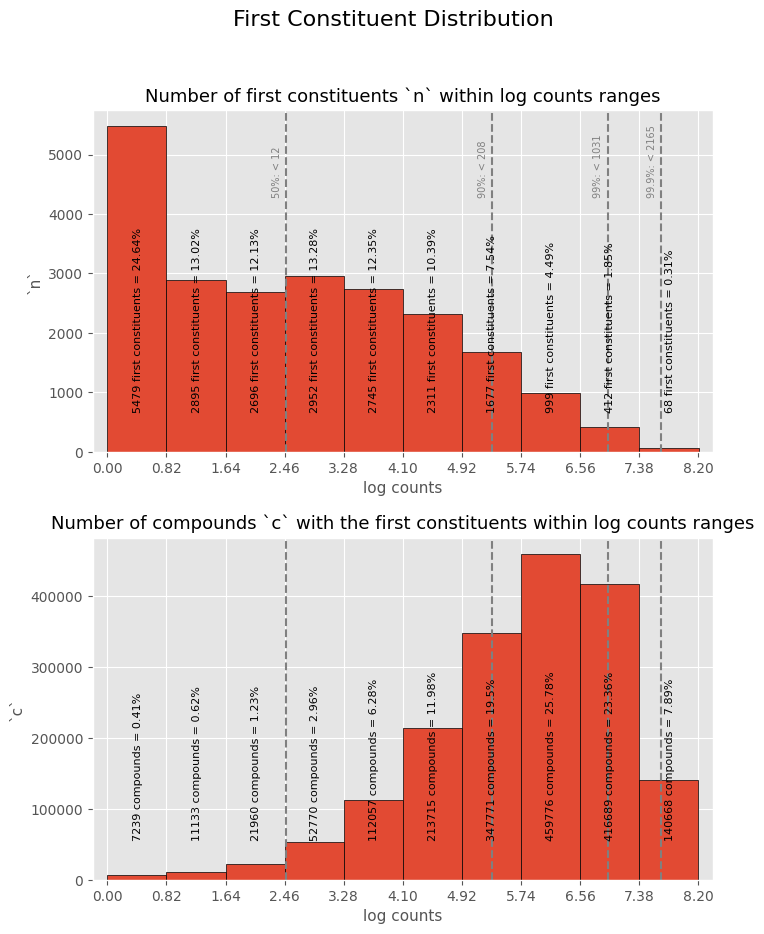

In [18]:
# first_constituents = gecodb["fc_count"].values  # We'll use `Counter` to print the constituents below
first_constituents = [compound.stems[0].component for compound in gecodb["compound"]]
first_constituents_counts = Counter(first_constituents)
first_constituents_log_counts = np.log(list(first_constituents_counts.values()))

# two subplots, one for number of counts,
# another for cumulative number of entries
fig, axis = plt.subplots(2, 1, figsize=(8, 5 * 2))
fig.suptitle("First Constituent Distribution", fontsize=16)
# apply full integer formatting for the y-axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, _: int(v)))
plt_hist = axis[0]
plt_bar = axis[1]

# upper plot: histogram "there are y first constituents with log count x1 to x2"
# plt_hist = axis[0]
data = plt_hist.hist(first_constituents_log_counts, edgecolor="black", bins=10)
ticks = data[1].round(2)  # for labels

plt_hist.set_xticks(ticks)
plt_hist.set_xlabel("log counts", fontsize=11)
plt_hist.set_ylabel("`n`", fontsize=11)

plt_hist.set_title("Number of first constituents `n` within log counts ranges", fontsize=13)

# Percentiles and Minimum Counts
percentages = [50, 90, 99, 99.9]
percentiles = np.percentile(first_constituents_log_counts, percentages)

for percentage, percentile in zip(percentages, percentiles):
	plt_hist.axvline(x=percentile, linestyle="--", color="grey")
	plt_bar.axvline(x=percentile, linestyle="--", color="grey")
	plt_hist.text(
		x=percentile - 0.2,
		y=plt_hist.get_ylim()[1] * 0.75,  # lift text to 25% of max height
		# s=f"{percentage}% of first constituents occur {int(np.exp(percentile))} times or less",
		s=f"{percentage}%: < {round(np.exp(percentile))}",
		rotation=90,
		fontsize=7,
		color="grey"
	)

# lower plot: bar chart "the y first constituents that have log counts from x1 to x2 make z compounds"
# plt_bar = axis[1]

# adjust the width and position of the bars
tick_counts = []
tick_ns = []
last_tick = -1
for i in range(len(ticks) - 1):
	if i < len(ticks) - 2:
		tick_log_counts = first_constituents_log_counts[
			(first_constituents_log_counts <= ticks[i + 1]) &
			(first_constituents_log_counts > last_tick)
		]
		last_tick = ticks[i + 1]
	else:
		tick_log_counts = first_constituents_log_counts[
			(first_constituents_log_counts > last_tick)
		]
	tick_n = len(tick_log_counts)
	tick_ns.append(tick_n)
	tick_count = np.exp(tick_log_counts).sum()  # summing counts in the same log counts range
	tick_counts.append(tick_count)

# shift bars to align them between tick marks
widths = np.diff(ticks)  # width of each bar is the difference between consecutive ticks
plt_bar.bar(ticks[:-1], tick_counts, width=widths, align="edge", edgecolor="black")  # align bars to edges
# plt_bar.bar(ticks, tick_counts, align="edge", edgecolor="black")  # align bars to edges

plt_bar.set_xticks(ticks)
plt_bar.set_xlabel("log counts", fontsize=11)
plt_bar.set_ylabel("`c`", fontsize=11)

plt_bar.set_title("Number of compounds `c` with the first constituents within log counts ranges", fontsize=13)

total_tick_count = sum(tick_counts)
total_tick_n = sum(tick_ns)
for x, n, count in zip(ticks, tick_ns, tick_counts):
	n_percentage = n / total_tick_n
	tick_percentage = count / total_tick_count
	plt_hist.text(
		x=x + 0.35,
		y=plt_hist.get_ylim()[1] * 0.12,	# bottom of the plot
		s=f"{int(n)} first constituents = {round(n_percentage * 100, 2)}%",
		rotation=90,
		fontsize=8
	)
	plt_bar.text(
		x=x + 0.35,
		y=plt_bar.get_ylim()[1] * 0.12,	# bottom of the plot
		s=f"{int(count)} compounds = {round(tick_percentage * 100, 2)}%",
		rotation=90,
		fontsize=8
	)

# increase space between subplots
plt.subplots_adjust(hspace=0.25)
# make x-axis of both plots match exactly
plt_hist.set_xlim(ticks[0] - 0.2, ticks[-1] + 0.2)
plt_bar.set_xlim(ticks[0] - 0.2, ticks[-1] + 0.2)

plt.savefig(
	os.path.join(out_dir, "fc_distr_v05.png"),
	format="png",
	dpi=1000,
	metadata={"Version": "gecodb_v05"}
)
plt.show()

In [23]:
most_frequent_fcs = {}
for fc, count in first_constituents_counts.most_common(10):
	print(f"{fc}\t{count}")
	most_frequent_fcs[fc] = count

pd.Series(most_frequent_fcs).to_csv(
	os.path.join(out_dir, "most_frequent_fcs_v05.tsv"),
	sep="\t",
	header=False,
	index=True
)

land	3643
haupt	3630
kind	3079
wasser	2985
spiel	2913
bild	2733
farbe	2636
stadt	2618
holz	2482
liebling	2464


In [25]:
# minimum log count
min_log_count = first_constituents_log_counts.min()
n_min_log_counts = len(first_constituents_log_counts[first_constituents_log_counts == min_log_count])
prec_min_log_counts = n_min_log_counts / len(first_constituents_log_counts)

print((line := (
		f"{round(prec_min_log_counts, 2)}% of first constituents have a minimum (GecoDB_v05) "
		f"count of {round(np.exp(min_log_count))} in GecoDB_v05"
	)
))

min_count_percs.write(f"{line}")
min_count_percs.close()

0.17% of first constituents have a minimum count of 1 in GecoDB_v05


## Link Distribution

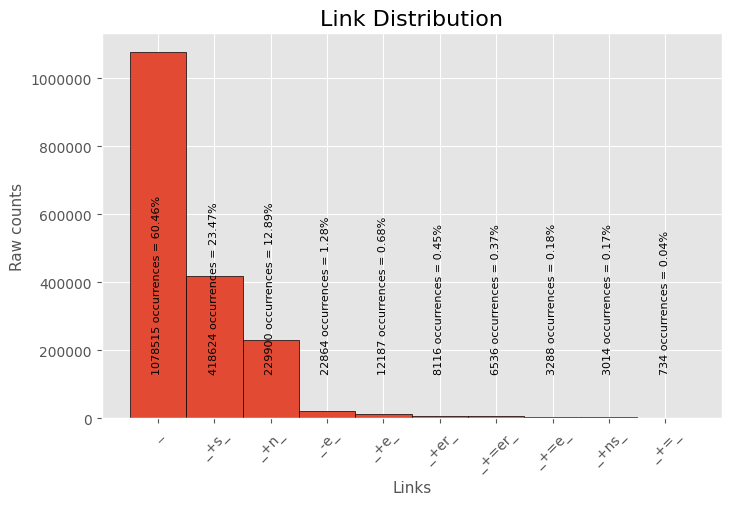

In [26]:
links = [compound.links[0].component for compound in gecodb["compound"]]
link_counts = Counter(links)
link_counts = {
    k: v for k, v in sorted(
        link_counts.items(),
        key=lambda i: i[1],
		reverse=True
	)
}

plt.figure(figsize=(8, 5))
# apply full integer formatting for the y-axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda v, _: int(v)))

plt.bar(link_counts.keys(), link_counts.values(), width=1.0, edgecolor="black")

# apply full integer formatting for the y-axis ticks
plt.xticks(rotation=45)	# better readability
plt.xlabel("Links", fontsize=11)
plt.ylabel("Raw counts", fontsize=11)

plt.title("Link Distribution", fontsize=16)

# add percentages
n_links = len(links)
link_percentages = {}
for i, (link, count) in enumerate(link_counts.items()):
    link_percentages[link] = count / n_links
    plt.text(
        x=i - 0.1,
        y=plt.ylim()[1] * 0.12,	# bottom of the plot
        s=f"{count} occurrences = {round(count / n_links * 100, 2)}%",
        rotation=90,
		fontsize=8
	)
    
plt_hist.set_xlim(-0.2, len(link_counts) + 0.2)

plt.savefig(
	os.path.join(out_dir, "link_distr_v05.png"),
	format="png",
    dpi=500,
	metadata={"Version": "gecodb_v05"}
)
plt.show()

In [27]:
link_percs = {}
for link, percentage in link_percentages.items():
	print(f"{link}\t{round(percentage, 4)}")
	link_percs[link] = round(percentage, 4)

pd.Series(link_percs).to_csv(
	os.path.join(out_dir, "link_percs_v05.tsv"),
	sep="\t",
	header=False,
	index=True
)

_	0.6046
_+s_	0.2347
_+n_	0.1289
_-e_	0.0128
_+e_	0.0068
_+er_	0.0045
_+=er_	0.0037
_+=e_	0.0018
_+ns_	0.0017
_+=_	0.0004
